In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon', quiet=True)


True

# Turnover Reason: Unsupervised Learning

In this model we change the target to turnover_reason. This is the reason given for why the employee left. Understanding this reason better will allow us to add more nuaunce to our initial predictive model. 

## Setup and Additional Exploration

This notebook assumes the exploratory notebook (`EDA.ipynb`) has already staged the master dataframe (`df`) and the list of continuous variables. The first few cells simply reload those shared objects with `%store`, validate that they are present, and remove any columns (such as the simulated `turnover_probability_generated`) that could leak target information into subsequent modeling steps.

### Restore Variables from EDA.ipynb

Use IPython's `%store -r` to restore the `df` dataframe and `continuous_vars` list that were stored at the end of `EDA.ipynb`.

**Important**: Make sure you've run `EDA.ipynb` first (at least up to the `%store` cells at the end) before running this notebook.

In [49]:
# Restore variables from EDA.ipynb (suppress warnings)
import warnings
warnings.filterwarnings('ignore')

%store -r df
%store -r continuous_vars

# Verify they loaded
if 'df' not in locals():
    raise RuntimeError("df was not restored. Make sure you've run EDA.ipynb and executed the %store cells at the end.")
if 'continuous_vars' not in locals():
    raise RuntimeError("continuous_vars was not restored. Make sure you've run EDA.ipynb and executed the %store cells at the end.")

In [50]:
# Verify the variables were restored successfully
print(f"DataFrame shape: {df.shape}")
print(f"Continuous variables ({len(continuous_vars)}): {continuous_vars[:5]}...")  # show first 5

# suppress not defined variable warning
df = df 
continuous_vars = continuous_vars
df.head(3)

DataFrame shape: (849999, 26)
Continuous variables (12): ['tenure_months', 'salary', 'performance_score', 'satisfaction_score', 'workload_score']...


,employee_id,role,job_level,department,tenure_months,salary,performance_score,satisfaction_score,workload_score,team_sentiment,...,soft_skills,burnout_risk,left_company,turnover_reason,risk_factors_summary,persona_name,role_complexity_score,career_progression_score,salary_rank,feedback_sentiment_score
0,SYN_00000000,Anonymous Employee,Mid,Research & Development,169,79704.579059,0.632482,0.623746,0.758117,0.662335,...,"[Communication, Creativity, Teamwork, Conflict...",0.866643,False,Not Applicable,Severe Burnout Risk,ChangeResistor,0.2,1.000000,0.490089,0.7351
1,SYN_00000001,Customer Success Manager,Manager,Research & Development,54,29694.288831,0.538587,0.982556,0.788416,0.934661,...,"[Conflict Resolution, Problem Solving, Creativ...",0.218996,False,Not Applicable,Low Risk,NewEnthusiast,0.2,1.000000,0.946494,0.9509
2,SYN_00000002,Administrative Assistant,Entry,HR,1,62208.470185,0.624656,0.767200,0.697617,0.888559,...,"[Problem Solving, Critical Thinking, Teamwork,...",0.541531,True,Personal / Relocation,Low Risk,NewEnthusiast,0.2,0.836495,0.620677,0.8999


In [51]:
# Remove data leakage column
df.drop(columns=['turnover_probability_generated'], errors='ignore', inplace=True)
continuous_vars.remove('turnover_probability_generated') if 'turnover_probability_generated' in continuous_vars else None

In [52]:
# Add salary rank 
df['salary_rank'] = df.groupby(['job_level', 'role'])['salary'].rank(pct=True, ascending=False)
df['salary_rank'].head()

0    0.490089
1    0.946494
2    0.620677
3    0.001948
4    0.770605
Name: salary_rank, dtype: float64

In [53]:
sia = SentimentIntensityAnalyzer()

# compound sentiment score
def get_vader_sentiment(text):
    scores = sia.polarity_scores(str(text))
    return scores['compound']  # normalized between -1 and 1

df['feedback_sentiment_score'] = df['recent_feedback'].apply(get_vader_sentiment)

### Feature Engineering For Turnover Context
- `salary_rank` captures each employee's relative pay within their job level + role so the clustering later can contrast compensation satisfaction beyond raw salary.
- `feedback_sentiment_score` converts open-ended feedback into a numeric sentiment signal using VADER; this becomes another continuous feature that correlates with burnout-related reasons.
These engineered columns are appended to the original continuous list (`continuous_vars_2`) so every downstream analysis—correlations, PCA, clustering, and modeling—operates on a richer description of each employee.

In [54]:
reasons = df['turnover_reason'].unique()
reasons = reasons[1:]
reasons

array(['Personal / Relocation', 'Compensation / Role Dissatisfaction',
       'Personal Reasons (Anomaly)', 'Burnout / Work-Life Balance',
       'Career Opportunity', 'Involuntary (Performance)'], dtype=object)

In [55]:
continuous_vars_2 = continuous_vars + ['feedback_sentiment_score', 'salary_rank']
target_var = ['left_company']

### Why iterate over turnover reasons?
The next cell slices the dataset by each `turnover_reason` (plus `Not Applicable` for stayers) and recomputes the correlations between every continuous feature and `left_company`. Saving a heatmap per reason exposes which factors consistently align with departures for specific narratives (burnout vs relocation, etc.) and also feeds an aggregate importance signal (`sum_corr_w_left`) that later guides which engineered features matter most.

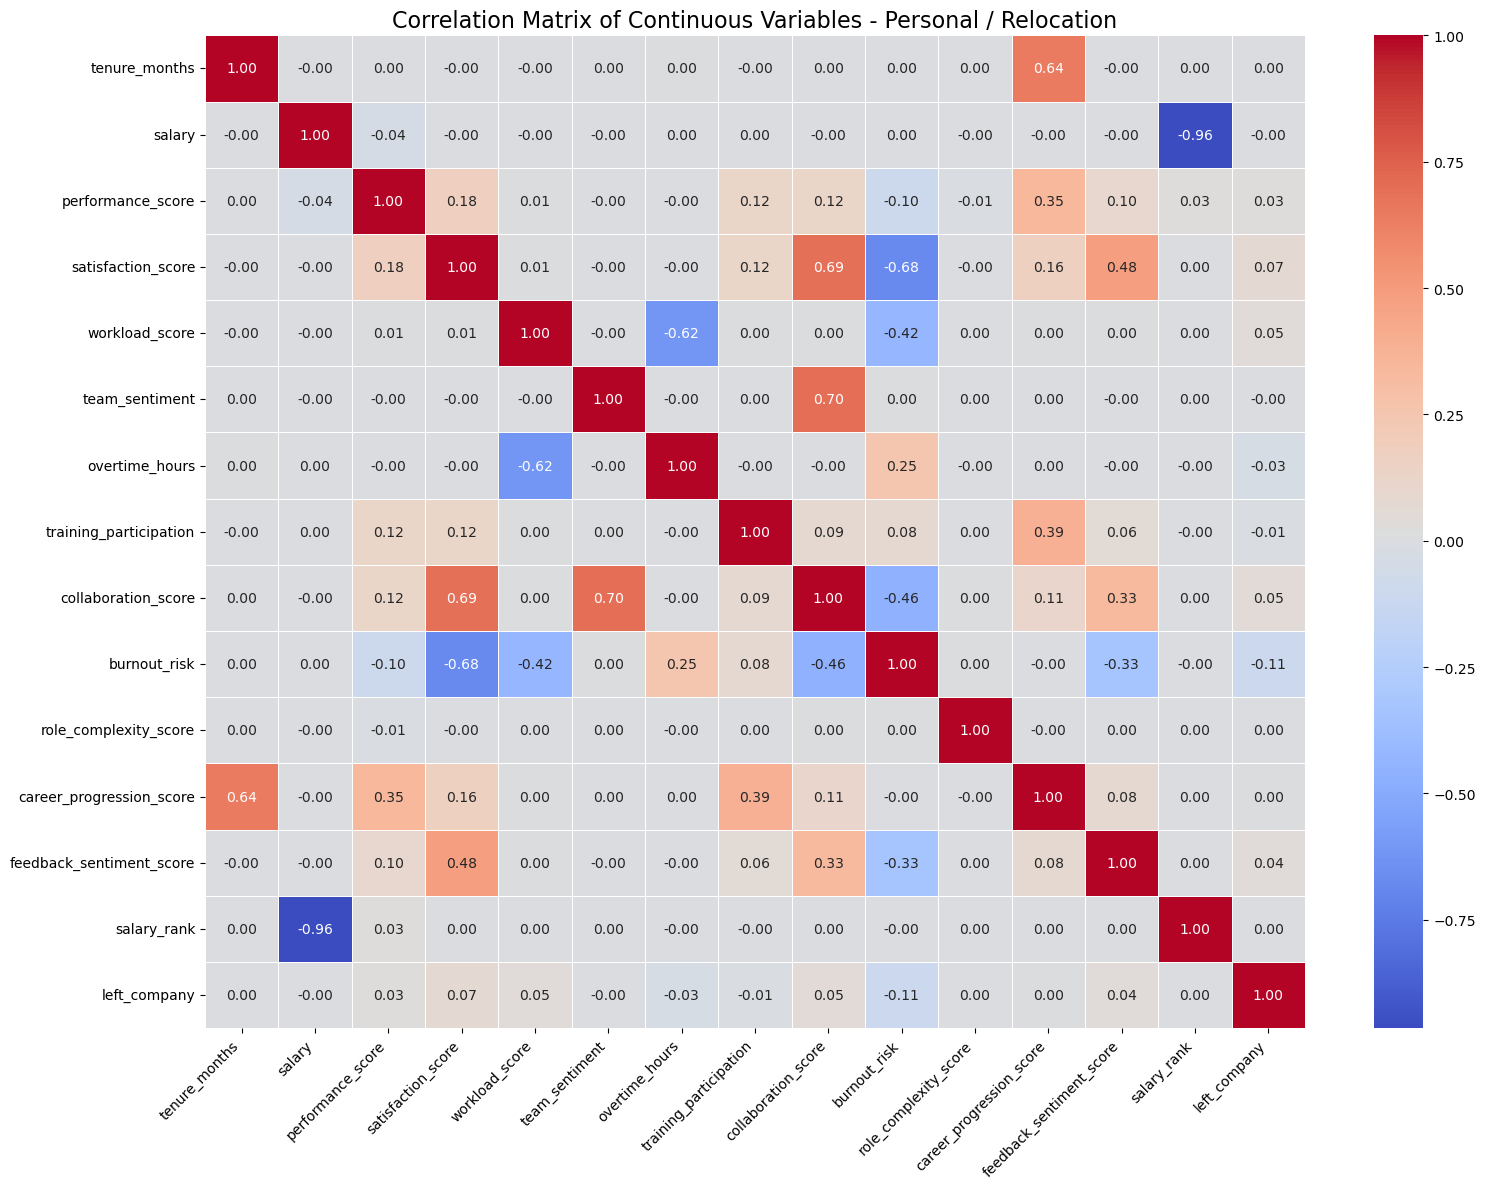

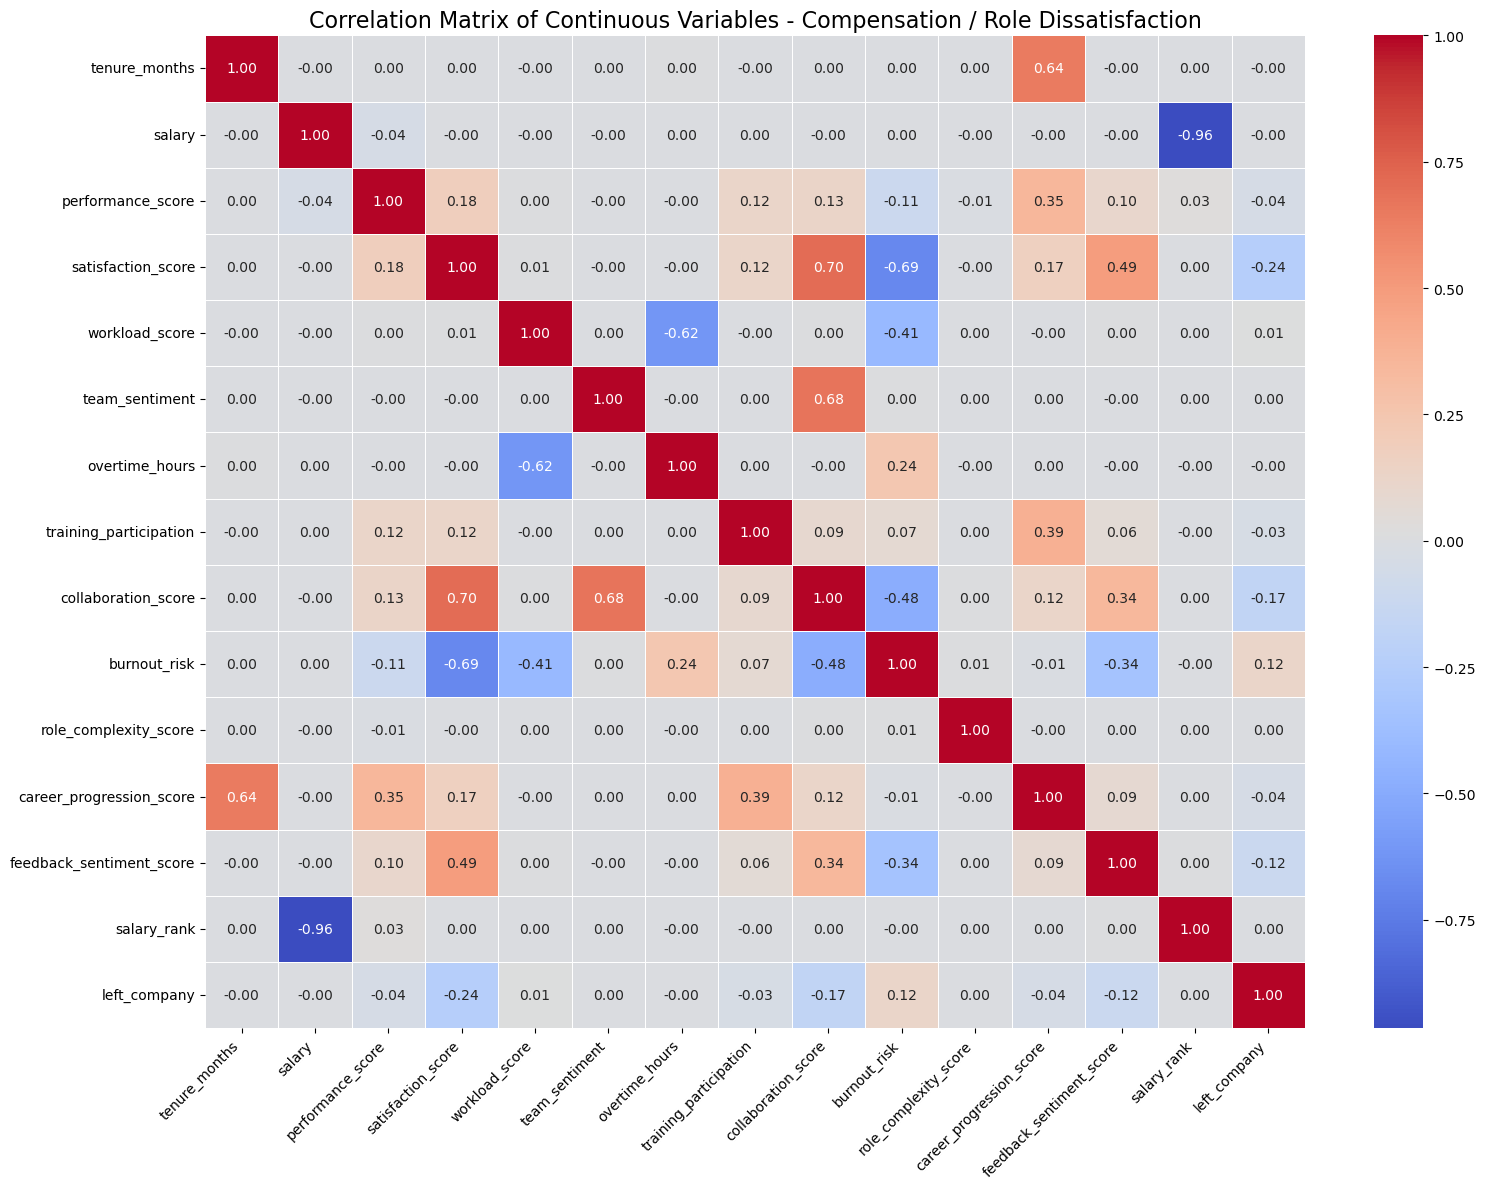

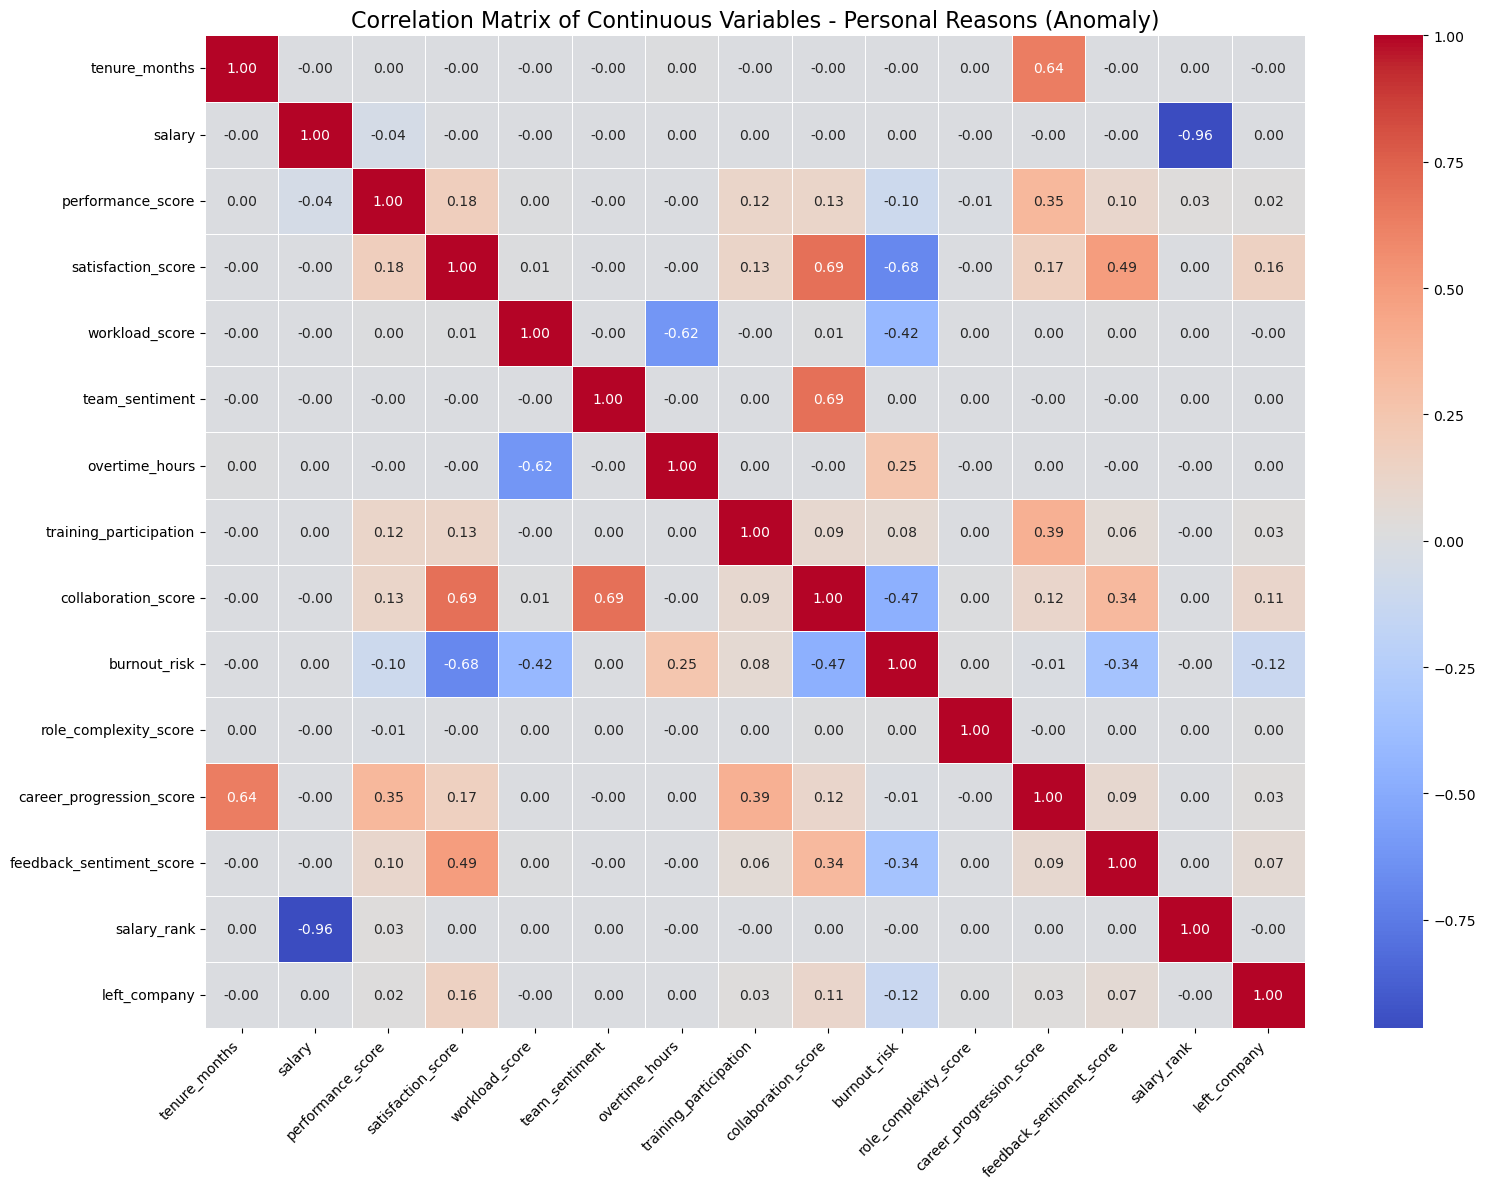

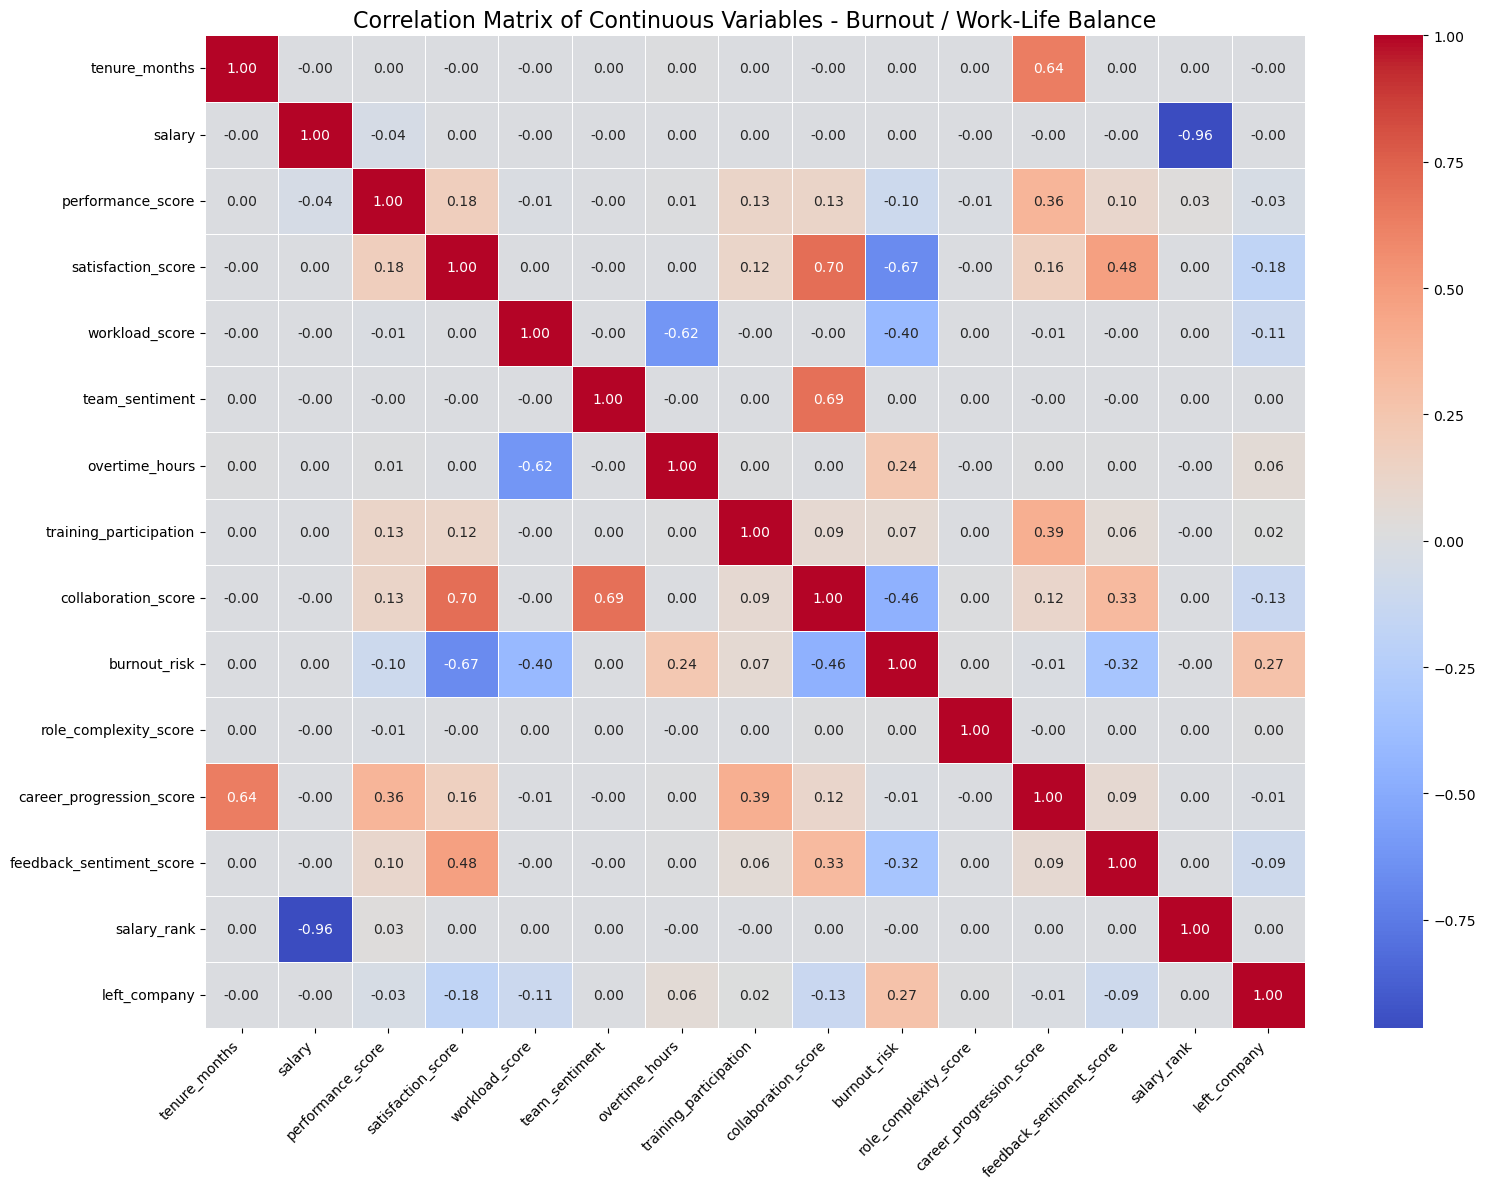

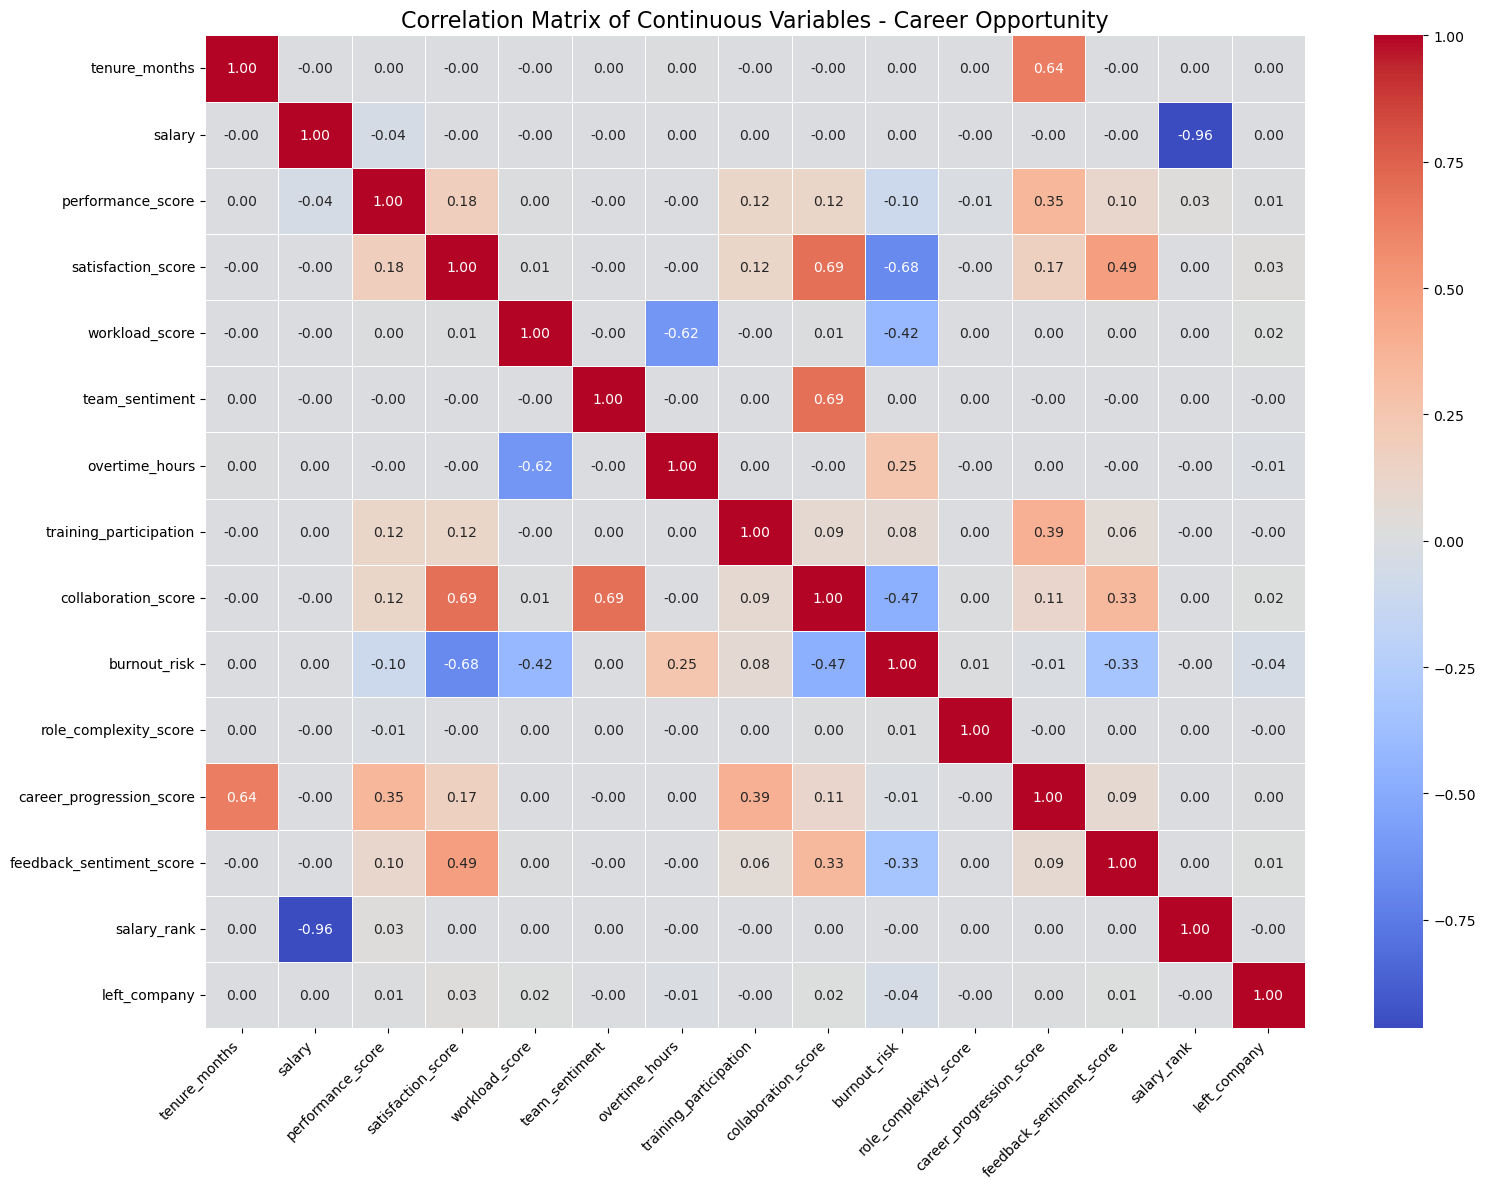

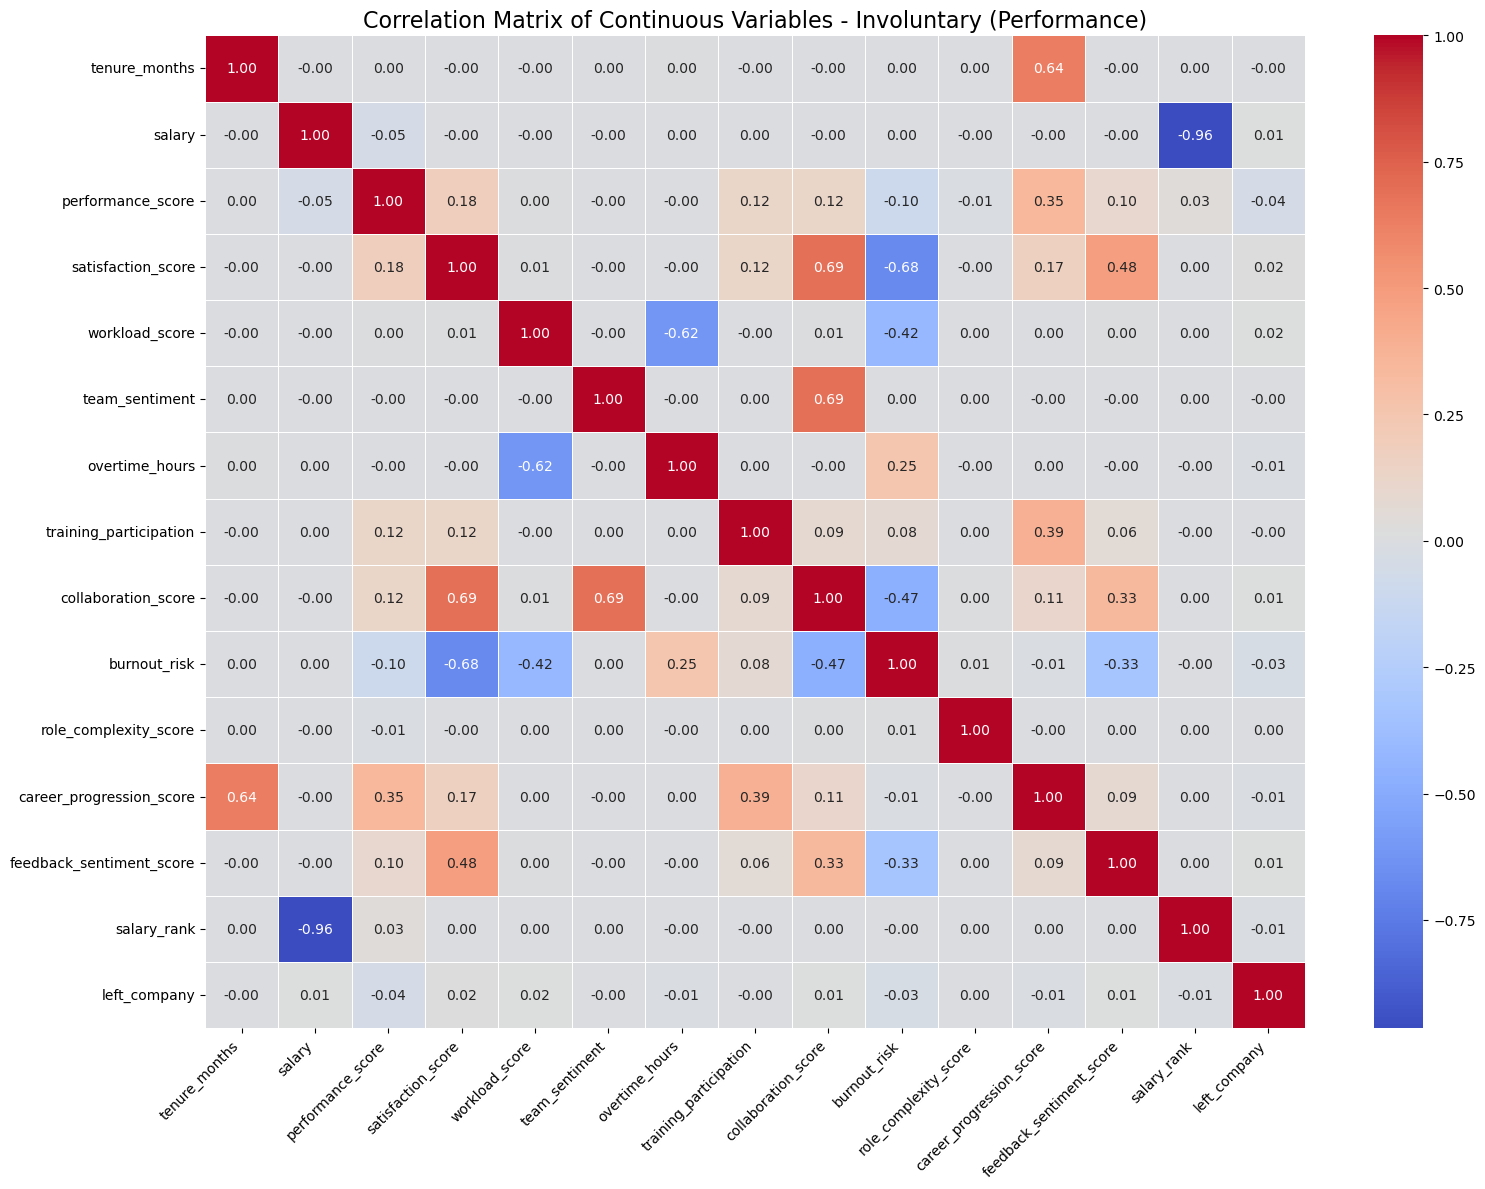

In [56]:
sum_corr_w_left=None

for reason in reasons: 

    reason_subset_df = df[(df['turnover_reason'] == reason) | 
                        (df['turnover_reason'] == 'Not Applicable')]

    p_corr_matrix = reason_subset_df[continuous_vars_2 + target_var].corr()

    if sum_corr_w_left is None:
        sum_corr_w_left = p_corr_matrix.iloc[-1, :].abs()
    else:
        sum_corr_w_left += p_corr_matrix.iloc[-1, :].abs()


    plt.figure(figsize=(16, 12))

    sns.heatmap(
        p_corr_matrix, 
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        linewidths=.5
    )

    plt.title(f'Correlation Matrix of Continuous Variables - {reason}', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    plot_filename = f'correlation_matrix_{reason[:8]}.png'
    plt.savefig('visualizations/' + plot_filename)

In [57]:
sum_corr_w_left.sort_values(ascending=False)

left_company                6.000000
satisfaction_score          0.690994
burnout_risk                0.690182
collaboration_score         0.480811
feedback_sentiment_score    0.344731
workload_score              0.197285
performance_score           0.173479
overtime_hours              0.120870
career_progression_score    0.092954
training_participation      0.087853
salary                      0.018955
salary_rank                 0.014965
role_complexity_score       0.007478
team_sentiment              0.005593
tenure_months               0.003834
Name: left_company, dtype: float64

# Data Preprocessing

## Encoding
It is necessary to encode the catagorical varibles for the PCA. Additionally, for the analysis, we filter on 'left_company'==True. 
We are interested in looking at the reson for the turnover. 



In [58]:
# One-hot encoding categorical features
categorical_vars = [ 'job_level', 'department', 'persona_name']


# Continuous vars to be scaled after train-test split

feature_cols = ['satisfaction_score',
                'burnout_risk', 
                'collaboration_score', 
                'feedback_sentiment_score',
                'workload_score',
                'performance_score',
                'overtime_hours']

###### only use the subset of people that left!!!
df_left = df[df['left_company'] == True].copy()

df_staged = df_left[feature_cols + categorical_vars]

df_encoded = pd.get_dummies(df_staged, columns=categorical_vars, drop_first=True)
print('df_encoded shape:', df_encoded.shape)

for c in df_encoded.columns:
    print(c)


df_encoded shape: (242526, 59)
satisfaction_score
burnout_risk
collaboration_score
feedback_sentiment_score
workload_score
performance_score
overtime_hours
job_level_Lead
job_level_Manager
job_level_Mid
job_level_Senior
department_Accounts Payable
department_Accounts Receiveable
department_Admin Offices
department_Analytics
department_Audit
department_Bakery
department_Compensation
department_Customer Service
department_Dairy
department_Employee Records
department_Executive
department_Executive Office
department_Finance
department_HR
department_HR Technology
department_Human Resources
department_IT/IS
department_Information Technology
department_Investment
department_Labor Relations
department_Legal
department_Meats
department_Operations
department_Processed Foods
department_Procurement
department_Produce
department_Production       
department_R&D
department_Recruitment
department_Research & Development
department_Sales
department_Sales & Marketing
department_Software Engineering
depa

## Apply PCA and Clustering 

In the originial dataset, the `role` varible 300+ distinct roles but didn't end up having an effect on our models. When using the one hot encoding method the dimensionality exploded. We are only using catagorical varibles "job_level", "persona_name" and "department". 

The next few cells therefore:
1. Split the encoded matrix into categorical dummy columns and continuous columns.
2. Standard-scale the continuous subset so PCA treats every metric on the same footing.
3. Stack everything back together (`X_PCA`) so the decomposition can capture interactions between demographic (job/dept/persona) and behavioral signals (satisfaction, burnout, sentiment, overtime, etc.).

In [59]:
job_columns = [col for col in df_encoded.columns if col.startswith('job_level_')]
persona_columns = [col for col in df_encoded.columns if col.startswith('persona_name_')]
dept_columns = [col for col in df_encoded.columns if col.startswith('department_')]

# features for PCA
ohe_features = df_encoded[job_columns+persona_columns+dept_columns]
other_features = df_encoded.drop(columns=job_columns+persona_columns+dept_columns)

scaler_other = StandardScaler()
other_features_scaled = scaler_other.fit_transform(other_features.values)

X_PCA = np.hstack([
    ohe_features.values,
    other_features_scaled
])

print(f"Shape of PCA train {X_PCA.shape}")

Shape of PCA train (242526, 59)


In [60]:
# fit PCA for feature reduction 
pca_full = PCA()
# pca_full = PCA(n_components=min(100, X_train_PCA.shape[1]) )
pca_full.fit_transform(X_PCA)

array([[ 2.00257134e+00,  4.09901669e-01, -6.99246999e-01, ...,
        -2.22530545e-04, -2.38922501e-04,  5.16923880e-05],
       [-1.82070001e+00,  1.45525382e+00, -1.61356543e+00, ...,
         2.05648977e-05, -2.45903000e-06,  1.31265481e-05],
       [-1.08960045e+00,  5.52990859e-01, -6.62050882e-01, ...,
         1.60696337e-04, -7.21594243e-05, -5.76534664e-05],
       ...,
       [ 5.30698109e-01, -1.14241971e+00, -9.76755461e-03, ...,
         8.66766064e-05,  5.22180443e-05,  5.90462407e-05],
       [-1.24820975e+00, -1.67165397e+00, -3.16399647e-01, ...,
        -2.17661139e-04, -1.79346108e-04,  2.99694427e-05],
       [-1.11509816e-01,  1.12445582e+00, -6.56396658e-01, ...,
        -2.69695722e-04, -1.09494253e-04,  3.13795447e-05]])

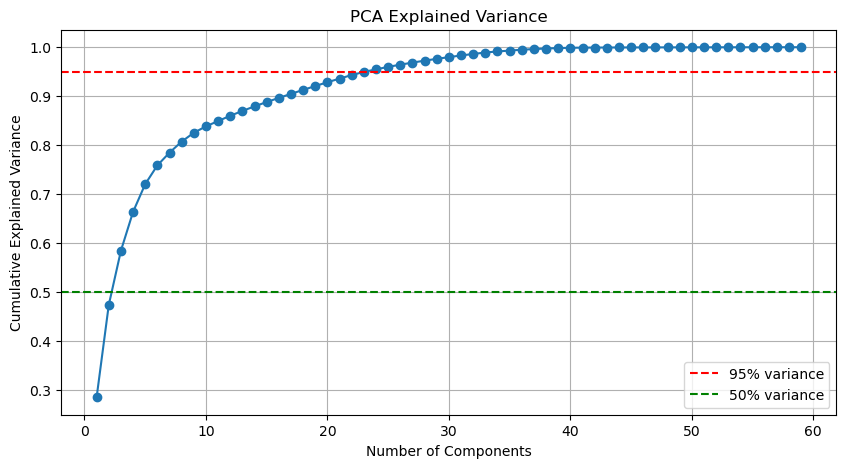

In [61]:
# Plot explained variance to choose number of components
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.axhline(y=0.50, color='g', linestyle='--', label='50% variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.show()


In [62]:


n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
# n components to explain 80% of the variance 
n_components = n_components_80 

print(f'Components needed for 80% variance: {n_components_80}')
print(f'Using n_components = {n_components} ')
print(f'Variance explained: {cumulative_variance[n_components-1]:.2%}')

pca = PCA(n_components=n_components)
X_pca_80_percent = pca.fit_transform(X_PCA)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"confirm variance explained when fit_transform with only {n_components}")
print(f'Variance explained: {cumulative_variance[-1]:.2%}')


Components needed for 80% variance: 8
Using n_components = 8 
Variance explained: 80.70%
confirm variance explained when fit_transform with only 8
Variance explained: 80.70%


## Cluster on PCA
With the dimensionality reduced to the components that explain ~80% of the variance, we can run KMeans in a space where clusters represent distinct turnover narratives instead of noisy high-dimensional points. This section first tunes `k` via silhouette scoring on a sample, then fits the final model on all leavers.

### Find the optimal cluster size using silhouette_score
Silhouette quickly measures how well each employee fits within its assigned cluster relative to the nearest alternative cluster. By sweeping `k` from 2 through 10 we can detect whether there are just a few broad exit themes (burnout vs relocation) or many micro-clusters. The best `k` maximizes the average silhouette, signalling clean separation.

In [63]:
sample_size = 50000 #save some time with random subsampling
sample_idx = np.random.choice(len(X_pca_80_percent), sample_size, replace=False)
X_pca_sample = X_pca_80_percent[sample_idx]

k_range = range(2,11)
silhouette_scores = []

for k in k_range:
    kmeans_tmp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_tmp = kmeans_tmp.fit_predict(X_pca_sample)
    s = silhouette_score(X_pca_sample, labels=labels_tmp)
    silhouette_scores.append(s)
    print(f"k={k}:   Silhouette_score: {s}")

best_k = k_range[np.argmax(silhouette_scores)]


k=2:   Silhouette_score: 0.23581489893175167
k=3:   Silhouette_score: 0.24083146287717067
k=3:   Silhouette_score: 0.24083146287717067
k=4:   Silhouette_score: 0.19279867357137712
k=4:   Silhouette_score: 0.19279867357137712
k=5:   Silhouette_score: 0.1935242650289537
k=5:   Silhouette_score: 0.1935242650289537
k=6:   Silhouette_score: 0.18889010095827619
k=6:   Silhouette_score: 0.18889010095827619
k=7:   Silhouette_score: 0.1865330403455037
k=7:   Silhouette_score: 0.1865330403455037
k=8:   Silhouette_score: 0.1673978287175492
k=8:   Silhouette_score: 0.1673978287175492
k=9:   Silhouette_score: 0.16331313944577006
k=9:   Silhouette_score: 0.16331313944577006
k=10:   Silhouette_score: 0.16264872457961754
k=10:   Silhouette_score: 0.16264872457961754


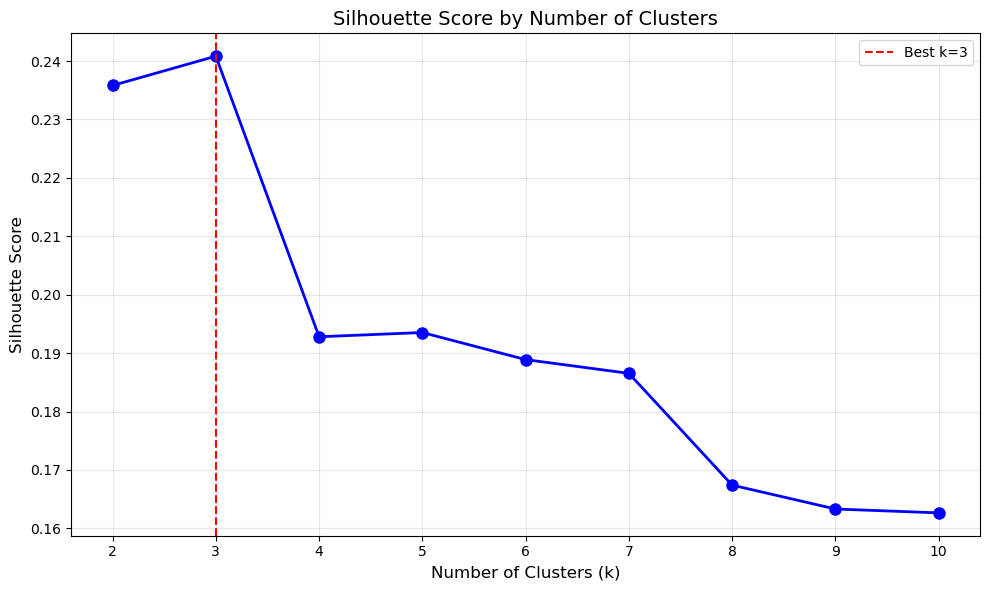

In [64]:
# Visually show the silhouette scores 
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k={best_k}')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score by Number of Clusters', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Fit KMeans with the k=3
No longer use the subsample.
The best k is 3.

In [65]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca_80_percent)

## Display Results

In [66]:
df_left['cluster'] = clusters

print(f"\nCluster sizes:")
print(df_left['cluster'].value_counts().sort_index())


Cluster sizes:
cluster
0     77009
1    105170
2     60347
Name: count, dtype: int64


In [67]:
# Print out cluster results

for cluster_id in range(3):
    cluster_data = df_left[df_left['cluster'] == cluster_id]
    print(f"Cluster id = {cluster_id} \n")

    print('Turnover Reason Distribution:')
    print(" Reason,                  Count,    Percentage")
    reason_dist = cluster_data['turnover_reason'].value_counts()
    for reason, count in reason_dist.items():
        p = count / len(cluster_data)
        print(f" {reason},  {count},  ({p*100}%)")

    print('\n\n')

Cluster id = 0 

Turnover Reason Distribution:
 Reason,                  Count,    Percentage
 Personal / Relocation,  43478,  (56.45833603864483%)
 Burnout / Work-Life Balance,  12222,  (15.87087223571271%)
 Personal Reasons (Anomaly),  7924,  (10.289706397953486%)
 Involuntary (Performance),  4639,  (6.023971224142633%)
 Career Opportunity,  4386,  (5.695438195535587%)
 Compensation / Role Dissatisfaction,  4360,  (5.661675908010752%)



Cluster id = 1 

Turnover Reason Distribution:
 Reason,                  Count,    Percentage
 Burnout / Work-Life Balance,  58283,  (55.41789483693068%)
 Compensation / Role Dissatisfaction,  23934,  (22.757440334696206%)
 Personal / Relocation,  18386,  (17.482171721973945%)
 Involuntary (Performance),  2644,  (2.514024912047162%)
 Career Opportunity,  1917,  (1.8227631453836646%)
 Personal Reasons (Anomaly),  6,  (0.005705048968336978%)



Cluster id = 2 

Turnover Reason Distribution:
 Reason,                  Count,    Percentage
 Burnout / Work

**Observation:**
The first cluster mainly consists of employees who left for "Burnout / Work-Life Balance" reasons or "Compensation / Role Dissatisfaction" reasons. These two reasons make up 78% for the points in the cluster. The second cluster consists of ~50% employees who relocated for personal reasons "Personal / Relocation". These are two very different reasons for leaving a company. With this new information we will train two models based on this segmented data. For the first model left_company column will only contain employees who left for Burnout / Work-Life Balance or Compensation / Role Dissatisfaction. The second model the left_company column will contain the other reasons "Personal / Relocation", "Personal Reasons (Anomaly)", "Involuntary (Performance)", "Career Opportunity"

### Segmented modeling strategy
Because the clusters map directly to distinct human stories (burnout/compensation vs relocation/personal change), the notebook now pivots to supervised learning with **two** tailored Random Forests:
1. **Cluster 1 style reasons** – only burnout and compensation exits vs everyone else (`left_company`) to highlight workload and reward signals.
2. **Cluster 2+ style reasons** – personal/relocation/performance exits vs stayers to emphasize life events or policy drivers.
Each model uses the same preprocessing recipe but is trained on its reason-specific subset so feature importances and metrics remain interpretable for that context.

# Train the random forest again!

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

In [69]:
# Model evaluation
def evaluate_model(y_true, y_pred, dataset):
  acc = accuracy_score(y_true, y_pred)
  prec = precision_score(y_true, y_pred)
  rec = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  roc = roc_auc_score(y_true, y_pred)
  print(dataset)
  print('Accuracy:', acc)
  print('Precision:', prec)
  print('Recall:', rec)
  print('F1-Score:', f1)
  print('ROC-AUC:', roc)

### Build two supervised datasets
- `c1_reason_subset_df` keeps burnout/compensation leavers plus `Not Applicable` stayers so the model focuses on operational pain points the company can address internally.
- `c2_reason_subset_df` captures all other reasons (relocation, personal anomaly, involuntary, career opportunity) to tease out signals that hint an employee is about to leave for external factors.
Both subsets reuse the same `feature_cols + categorical_vars` so comparisons between the models remain apples-to-apples.

In [70]:
c1_reason_subset_df = df[(df['turnover_reason'] == 'Burnout / Work-Life Balance') | 
                         (df['turnover_reason'] == 'Compensation / Role Dissatisfaction') |
                         (df['turnover_reason'] == 'Not Applicable')].copy() #NA for left_company = False
c1_reason_subset_df = c1_reason_subset_df[feature_cols+categorical_vars+['left_company']].copy()

c2_reason_subset_df = df[(df['turnover_reason'] != 'Burnout / Work-Life Balance') & 
                         (df['turnover_reason'] != 'Compensation / Role Dissatisfaction')].copy()

In [71]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

### Shared preprocessing recipe
Each model applies the same `ColumnTransformer`: standardize numeric engagement metrics and one-hot encode the categorical trio (job level, department, persona). Converting the transformed arrays back into DataFrames with readable column names makes it easy to inspect feature importances later.

In [72]:
X = c1_reason_subset_df[feature_cols+categorical_vars]
y = c1_reason_subset_df['left_company']

X_train_c1, X_test_c1, y_train_c1, y_test_c1 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify if classification
)

#consice but it needs to be converted back to pd df
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
    ])

X_train_c1_transformed = preprocessor.fit_transform(X_train_c1)
X_test_c1_transformed = preprocessor.transform(X_test_c1)

num_features = feature_cols
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_vars)
all_features = list(num_features) + list(cat_features)

X_train_c1_t = pd.DataFrame(X_train_c1_transformed, columns=all_features, index=X_train_c1.index)
X_test_c1_t = pd.DataFrame(X_test_c1_transformed, columns=all_features, index=X_test_c1.index)


### Model 1: Burnout & compensation leavers
Key steps below:
1. Under-sample the majority class (`left_company=False`) to give departures equal voice during training.
2. Train a moderately deep Random Forest (400 trees, depth 10) with `class_weight='balanced_subsample'` so residual imbalance is handled per-tree.
3. Evaluate on both the resampled train set and the untouched test set, then inspect confusion matrices and top-20 feature importances to explain recommendations back to HR.

Using 'Burnout / Work-Life Balance' and 'Compensation / Role Dissatisfaction' 
Train Set
Accuracy: 0.6936105405452854
Precision: 0.6343114986694597
Recall: 0.9143624585242535
F1-Score: 0.749015786956975
ROC-AUC: 0.6936105405452854
Test Set
Accuracy: 0.5532043125962633
Precision: 0.2876342593106819
Recall: 0.9092377374389944
F1-Score: 0.43701903604698256
ROC-AUC: 0.6892670660566701


Train Set
Accuracy: 0.6936105405452854
Precision: 0.6343114986694597
Recall: 0.9143624585242535
F1-Score: 0.749015786956975
ROC-AUC: 0.6936105405452854
Test Set
Accuracy: 0.5532043125962633
Precision: 0.2876342593106819
Recall: 0.9092377374389944
F1-Score: 0.43701903604698256
ROC-AUC: 0.6892670660566701




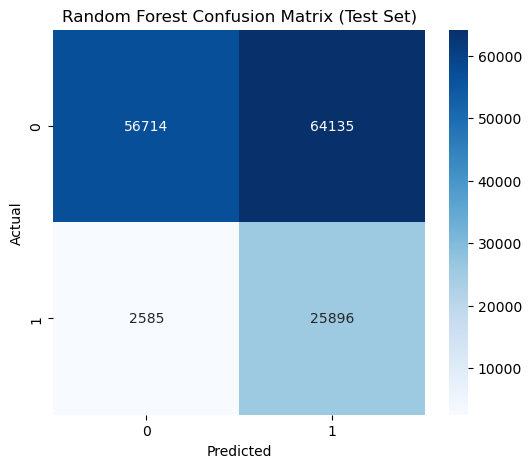

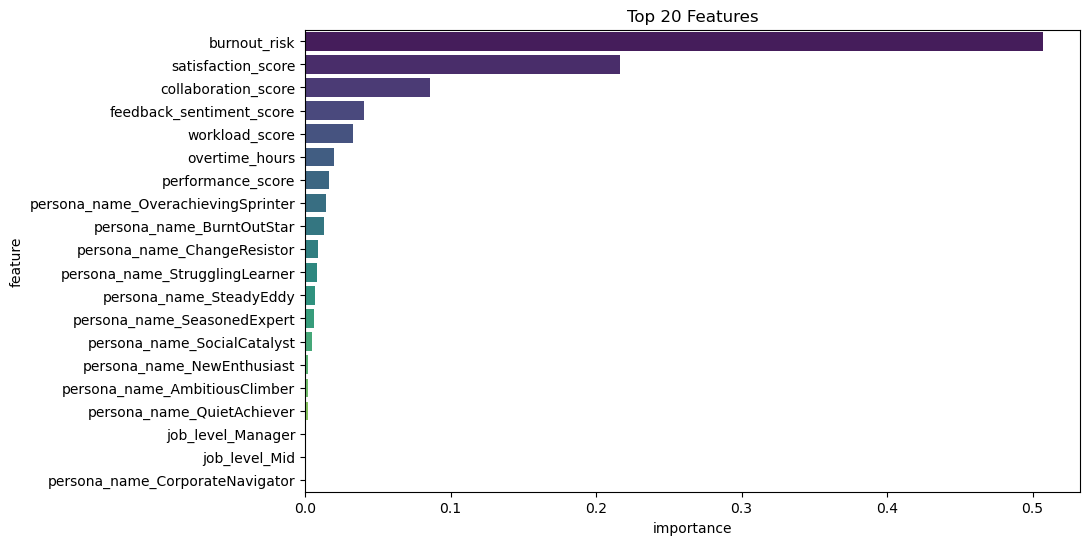

In [78]:
print("Using 'Burnout / Work-Life Balance' and 'Compensation / Role Dissatisfaction' " )

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_c1_t, y_train_c1)

# Initialize model
rf_model_1 = RandomForestClassifier(
    n_estimators=400,
    max_depth=10,
    random_state=42,
    bootstrap=True,
    class_weight='balanced_subsample',
    n_jobs=-1
)

# Fit model
rf_model_1.fit(X_train_res, y_train_res)

y_train_pred = rf_model_1.predict(X_train_res)
y_test_pred = rf_model_1.predict(X_test_c1_t)

# Evaluate
evaluate_model(y_train_res, y_train_pred, 'Train Set')
evaluate_model(y_test_c1, y_test_pred, 'Test Set')
print('\n')

# Confusion matrix
cm = confusion_matrix(y_test_c1, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importances
importances = rf_model_1.feature_importances_
features = X_train_res.columns
feat_imp_df = pd.DataFrame({'feature': features, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df, palette='viridis')
plt.title('Top 20 Features')
plt.show()



In [79]:
X = c2_reason_subset_df[feature_cols+categorical_vars]
y = c2_reason_subset_df['left_company']

X_train_c2, X_test_c2, y_train_c2, y_test_c2 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify if classification
)

# Concise but it needs to be converted back to pd df
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
    ])

X_train_c2_transformed = preprocessor.fit_transform(X_train_c2)
X_test_c2_transformed = preprocessor.transform(X_test_c2)

num_features = feature_cols
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_vars)
all_features = list(num_features) + list(cat_features)

X_train_c2_t = pd.DataFrame(X_train_c2_transformed, columns=all_features, index=X_train_c2.index)
X_test_c2_t = pd.DataFrame(X_test_c2_transformed, columns=all_features, index=X_test_c2.index)


### Model 2: Personal / relocation / other exits
This second supervised dataset mirrors the first but targets reasons largely outside day-to-day workload (relocation, personal changes, performance actions, career moves). Reusing the same preprocessing ensures we can compare feature importances directly and discover whether different warning signs show up for this cohort.

NOT using 'Burnout / Work-Life Balance' and 'Compensation / Role Dissatisfaction' 
Train Set
Accuracy: 0.6354777897076082
Precision: 0.6134512645192318
Recall: 0.7325526230367799
F1-Score: 0.6677325928749851
ROC-AUC: 0.6354777897076083
Test Set
Accuracy: 0.5644502543810063
Precision: 0.20641438085562705
Recall: 0.7305368289637952
F1-Score: 0.32188081014774966
ROC-AUC: 0.633806214391359


Train Set
Accuracy: 0.6354777897076082
Precision: 0.6134512645192318
Recall: 0.7325526230367799
F1-Score: 0.6677325928749851
ROC-AUC: 0.6354777897076083
Test Set
Accuracy: 0.5644502543810063
Precision: 0.20641438085562705
Recall: 0.7305368289637952
F1-Score: 0.32188081014774966
ROC-AUC: 0.633806214391359




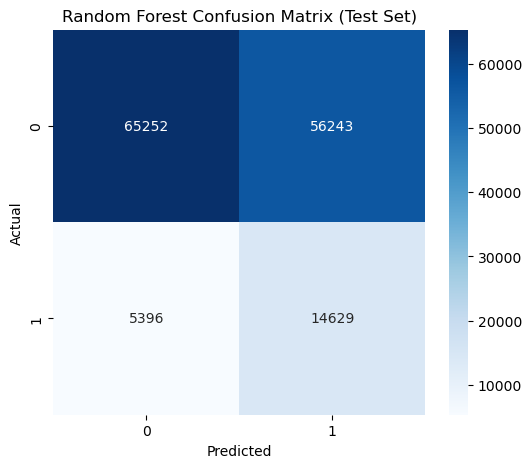

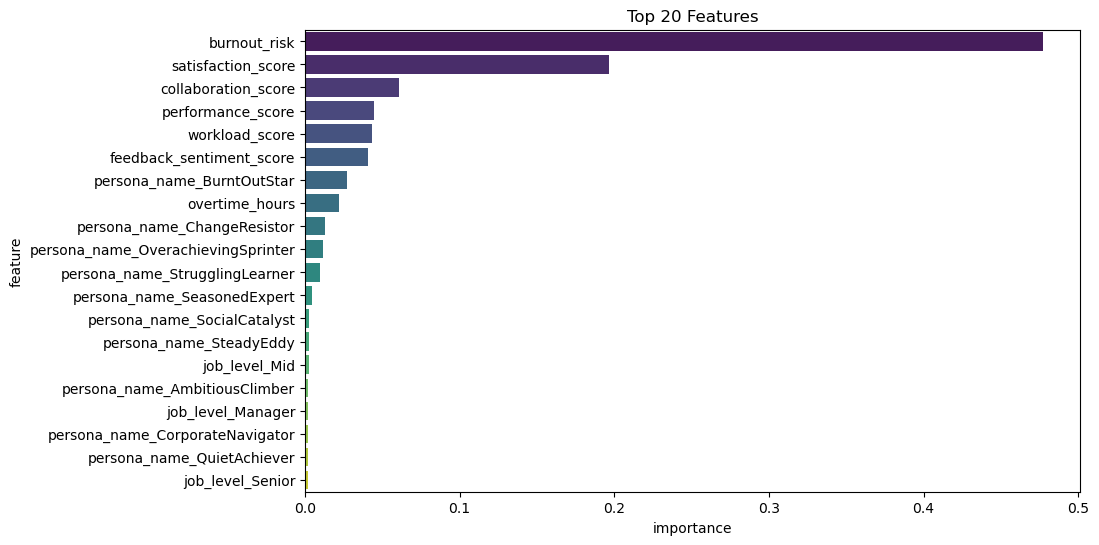

In [80]:
print("NOT using 'Burnout / Work-Life Balance' and 'Compensation / Role Dissatisfaction' " )

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_c2_t, y_train_c2)

# Initialize model
rf_model_1 = RandomForestClassifier(
    n_estimators=400,
    max_depth=10,
    random_state=42,
    bootstrap=True,
    class_weight='balanced_subsample',
    n_jobs=-1
)

# Fit model
rf_model_1.fit(X_train_res, y_train_res)

y_train_pred = rf_model_1.predict(X_train_res)
y_test_pred = rf_model_1.predict(X_test_c2_t)

# Evaluate
evaluate_model(y_train_res, y_train_pred, 'Train Set')
evaluate_model(y_test_c2, y_test_pred, 'Test Set')
print('\n')

# Confusion matrix
cm = confusion_matrix(y_test_c2, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importances
importances = rf_model_1.feature_importances_
features = X_train_res.columns
feat_imp_df = pd.DataFrame({'feature': features, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df, palette='viridis')
plt.title('Top 20 Features')
plt.show()



## Gradient Boosting Baseline (XGBoost)
The Random Forests above work well for segmented cohorts, but it's helpful to benchmark a single boosted tree model on the full population. This XGBoost run reuses the curated `feature_cols` + `categorical_vars`, applies the same scaling/encoding recipe, and reports how well a modern gradient boosting classifier predicts `left_company`.

In [81]:
from xgboost import XGBClassifier

In [82]:
# Prepare unified dataset for XGBoost benchmark
X_all = df[feature_cols + categorical_vars].copy()
y_all = df['left_company'].copy()

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
 )

xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
    ]
 )

X_train_all_t = xgb_preprocessor.fit_transform(X_train_all)
X_test_all_t = xgb_preprocessor.transform(X_test_all)

num_features = feature_cols
cat_features = xgb_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_vars)
xgb_feature_names = list(num_features) + list(cat_features)
scale_pos_weight = (len(y_train_all) - y_train_all.sum()) / max(y_train_all.sum(), 1)

In [83]:
# Train and evaluate XGBoost
xgb_model = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.5,
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_all_t, y_train_all)

y_train_pred = xgb_model.predict(X_train_all_t)
y_test_pred = xgb_model.predict(X_test_all_t)
y_train_proba = xgb_model.predict_proba(X_train_all_t)[:, 1]
y_test_proba = xgb_model.predict_proba(X_test_all_t)[:, 1]

evaluate_model(y_train_all, y_train_pred, 'XGB Train Set')
print('\n')
evaluate_model(y_test_all, y_test_pred, 'XGB Test Set')
print('\n')
print('Train ROC-AUC (probabilities):', roc_auc_score(y_train_all, y_train_proba))
print('Test ROC-AUC (probabilities):', roc_auc_score(y_test_all, y_test_proba))

XGB Train Set
Accuracy: 0.5504155153169343
Precision: 0.3493168425823998
Recall: 0.6672885924719489
F1-Score: 0.4585754436795696
ROC-AUC: 0.585521953249255


XGB Test Set
Accuracy: 0.5280117647058824
Precision: 0.3288754192776022
Recall: 0.6286568395010823
F1-Score: 0.43183878094374895
ROC-AUC: 0.5582438072150459


Train ROC-AUC (probabilities): 0.6255267438715821
Test ROC-AUC (probabilities): 0.577298741825413
Train ROC-AUC (probabilities): 0.6255267438715821
Test ROC-AUC (probabilities): 0.577298741825413


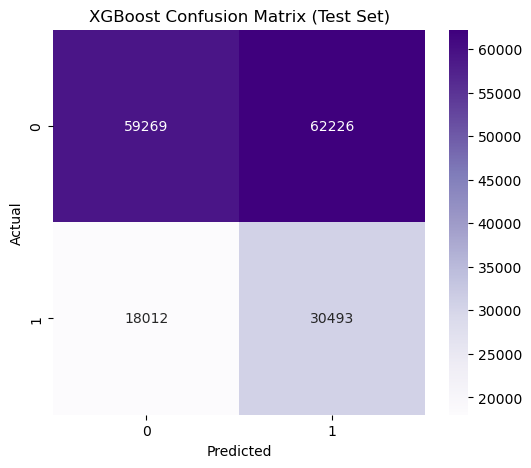

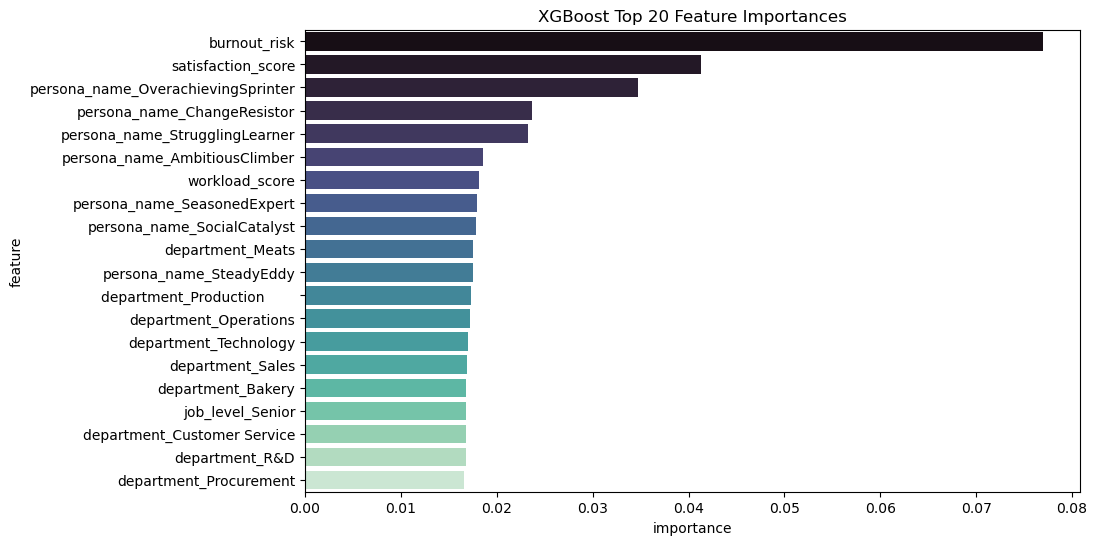

In [84]:
# Visualize evaluation artifacts
cm = confusion_matrix(y_test_all, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title('XGBoost Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

xgb_feat_importances = pd.DataFrame({
    'feature': xgb_feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(data=xgb_feat_importances, x='importance', y='feature', palette='mako')
plt.title('XGBoost Top 20 Feature Importances')
plt.show()